In [63]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [64]:
%cd ../content/drive/MyDrive/ConvolutionalAutoEncorder/

[Errno 2] No such file or directory: '../content/drive/MyDrive/ConvolutionalAutoEncorder/'
/content/drive/MyDrive/ConvolutionalAutoEncorder


In [65]:
import random
import math
import time
import pandas as pd
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
%matplotlib inline

import torch
import torch.utils.data as data
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from torchvision import transforms

In [80]:
class ConvAutoEncoder(nn.Module):
    def __init__(self,multi_num=1):
        super(ConvAutoEncoder, self).__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(
                in_channels=1,
                out_channels=multi_num*8,
                kernel_size=3,
                stride=1,
                padding=1),
            nn.BatchNorm2d(multi_num*8),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2,2)
        )

        self.conv2 = nn.Sequential(
            nn.Conv2d(
                in_channels=multi_num*8,
                out_channels=multi_num*8,
                kernel_size=3,
                stride=1,
                padding=1),
            nn.BatchNorm2d(multi_num*8),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2,2)
        )

        self.conv3 = nn.Sequential(
            nn.Conv2d(
                in_channels=multi_num*8,
                out_channels=multi_num*16,
                kernel_size=3,
                stride=1,
                padding=1),
            nn.BatchNorm2d(multi_num*16),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2,2)
        )

        self.conv4 = nn.Sequential(
            nn.Conv2d(
                in_channels=multi_num*16,
                out_channels=multi_num*32,
                kernel_size=3,
                stride=1,
                padding=1),
            nn.BatchNorm2d(multi_num*32),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2,2)
        )

        self.trans_conv1 = nn.Sequential(
            nn.ConvTranspose2d(
                in_channels=multi_num*32,
                out_channels=multi_num*16,
                kernel_size=2,
                stride=2
            ),
            nn.BatchNorm2d(multi_num*16),
            nn.ReLU(inplace=True)
        )

        self.trans_conv2 = nn.Sequential(
            nn.ConvTranspose2d(
                in_channels=multi_num*16,
                out_channels=multi_num*8,
                kernel_size=2,
                stride=2
            ),
            nn.BatchNorm2d(multi_num*8),
            nn.ReLU(inplace=True)
        )

        self.trans_conv3 = nn.Sequential(
            nn.ConvTranspose2d(
                in_channels=multi_num*8,
                out_channels=multi_num*8,
                kernel_size=2,
                stride=2
            ),
            nn.BatchNorm2d(multi_num*8),
            nn.ReLU(inplace=True)
        )

        self.trans_conv4 = nn.Sequential(
            nn.ConvTranspose2d(
                in_channels=multi_num*8,
                out_channels=1,
                kernel_size=2,
                stride=2
            ),
            nn.BatchNorm2d(1),
            nn.Tanh()
        )

    def forward(self, x):
        out = list()
        out.append(self.conv1(x))
        out.append(self.conv2(out[0]))
        out.append(self.conv3(out[1]))
        # out.append(self.conv4(out[2]))
        # out.append(self.trans_conv1(out[3]))
        out.append(self.trans_conv2(out[2]))
        out.append(self.trans_conv3(out[3]))
        out.append(self.trans_conv4(out[4]))

        return out

In [81]:
def make_datapath_list(mode="train"):

    image_list = list()
    if mode=="train":
        for index in range(1000):
            image_path = f"./data/fasion_train_images/image_5_{index}.jpg"
            image_list.append(image_path)
            image_path = f"./data/fasion_train_images/image_7_{index}.jpg"
            image_list.append(image_path)
            image_path = f"./data/fasion_train_images/image_9_{index}.jpg"
            image_list.append(image_path)
    if mode=="test":
        for index in range(100):
            for i in range(10):
                image_path = f"./data/fasion_test_images/image_{i}_{index}.jpg"
                image_list.append(image_path)

    return image_list

class ImageTransform():
    def __init__(self, mean, std):
        self.data_transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize(mean, std)
        ])

    def __call__(self, image):
        return self.data_transform(image)

class CAE_Image_Dataset(data.Dataset):

    def __init__(self, image_list, transform):
        self.image_list = image_list
        self.transform = transform

    def __len__(self):
        return len(self.image_list)

    def __getitem__(self, index):
        image_path = self.image_list[index]
        image = Image.open(image_path)

        image_transformed = self.transform(image)

        return image_transformed

torch.Size([16, 1, 64, 64])


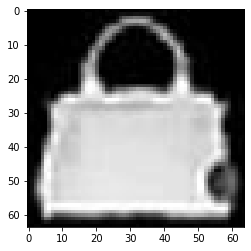

In [82]:
# Check
train_image_list = make_datapath_list(mode="train")

mean = (0.5,)
std = (0.5,)
train_dataset = CAE_Image_Dataset(
    image_list=train_image_list,
    transform=ImageTransform(mean,std)
)

batch_size = 16

train_dataloader = data.DataLoader(
    train_dataset,
    batch_size=batch_size,
    shuffle=True
)

batch_iterator = iter(train_dataloader)
images = next(batch_iterator)
print(images.size())
plt.imshow(images[0][0],'gray')

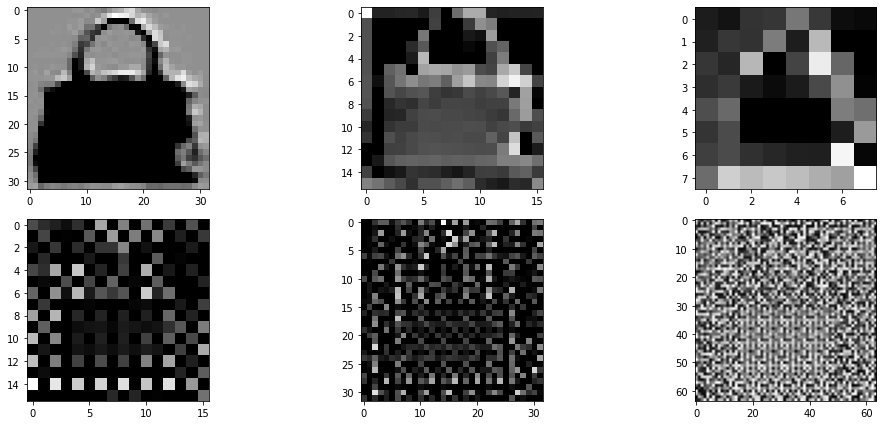

In [83]:
CAE_test = ConvAutoEncoder(multi_num=16)

input_x = images[0][0]
input_x = input_x.view(1,1,input_x.size(0),input_x.size(1))

output = CAE_test(input_x)

fig = plt.figure(figsize=(15,6))
for i in range(6):
    plt.subplot(2,3,i+1)
    image = output[i][0][0].detach().numpy()
    plt.imshow(image,'gray')
plt.tight_layout(pad=1.0)

In [84]:
def train_model(CAE, dataloader, epochs, model_name=None):
    # device
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    print(f"Device:{device}")

    # loss function, optimizer
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(CAE.parameters(), lr=0.001)

    # outher settings
    CAE.to(device)
    CAE.train()
    batch_size = 16
    train_losses = list()
    torch.backends.cudnn.benchmark = True

    # training loop
    for epoch in range(epochs):
        epoch_start_time = time.time()
        epoch_loss = 0.0

        print(f"----------------")
        print(f"Epoch:{epoch}/{epochs-1}")

        # train per batch
        for images in dataloader:

            epoch_batch_size = images.size()[0]

            if epoch_batch_size == 1:
                continue

            images = images.to(device)

            optimizer.zero_grad()

            outputs = CAE(images)

            loss = criterion(outputs[5],images)
            loss.backward()
            optimizer.step()

            epoch_loss += loss.item()*epoch_batch_size
        
        epoch_loss = epoch_loss/len(dataloader)
        print(f"Loss:{epoch_loss:.4f}")
        epoch_finish_time = time.time()
        print(f"Time:{epoch_finish_time-epoch_start_time:.4f} sec.")
        train_losses.append(epoch_loss)
        print(f"----------------")

        if model_name != None and epoch%50 == 0:
              file_name = f"{model_name}_{epoch}.pth"
              torch.save(CAE.state_dict(), f"model/gpu_{file_name}")
              torch.save(CAE.to('cpu').state_dict(), f"model/cpu_{file_name}")
              CAE.to(device)

    print("Finished!")

    return CAE, train_losses

In [85]:
epochs = 101

train_image_list = make_datapath_list()

mean = (0.5,)
std = (0.5,)
train_dataset = CAE_Image_Dataset(
    image_list=train_image_list,
    transform=ImageTransform(mean,std)
)

batch_size = 16

train_dataloader = data.DataLoader(
    train_dataset,
    batch_size=batch_size,
    shuffle=True
)

CAE = ConvAutoEncoder(multi_num=16)

In [86]:
CAE_trained, train_losses = train_model(CAE,train_dataloader,epochs,model_name="Fasion_CAE_16")

Device:cuda:0
----------------
Epoch:0/100
Loss:2.6727
Time:4.1151 sec.
----------------
----------------
Epoch:1/100
Loss:1.2994
Time:4.3076 sec.
----------------
----------------
Epoch:2/100
Loss:0.8542
Time:4.2974 sec.
----------------
----------------
Epoch:3/100
Loss:0.6246
Time:4.2098 sec.
----------------
----------------
Epoch:4/100
Loss:0.4794
Time:4.1132 sec.
----------------
----------------
Epoch:5/100
Loss:0.4040
Time:4.1696 sec.
----------------
----------------
Epoch:6/100
Loss:0.3371
Time:4.1052 sec.
----------------
----------------
Epoch:7/100
Loss:0.2882
Time:4.0880 sec.
----------------
----------------
Epoch:8/100
Loss:0.3082
Time:4.1310 sec.
----------------
----------------
Epoch:9/100
Loss:0.2210
Time:4.1497 sec.
----------------
----------------
Epoch:10/100
Loss:0.2119
Time:4.2418 sec.
----------------
----------------
Epoch:11/100
Loss:0.1797
Time:4.4380 sec.
----------------
----------------
Epoch:12/100
Loss:0.1676
Time:4.3276 sec.
----------------
--------

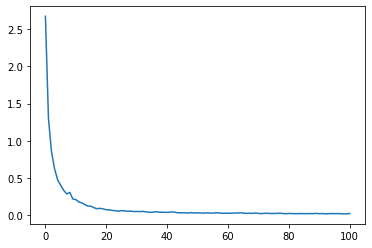

In [87]:
plt.plot(range(epochs),train_losses)

In [88]:
# test
test_image_list = make_datapath_list(mode="test")

mean = (0.5,)
std = (0.5,)
test_dataset = CAE_Image_Dataset(
    image_list=test_image_list,
    transform=ImageTransform(mean,std)
)

batch_size = 10

test_dataloader = data.DataLoader(
    test_dataset,
    batch_size=batch_size,
    shuffle=True
)

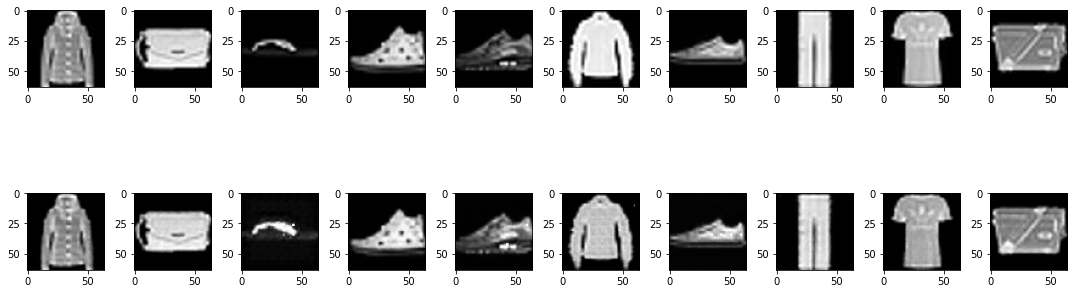

In [89]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
batch_iterator = iter(test_dataloader)
images = next(batch_iterator)

fig = plt.figure(figsize=(15,6))
for i in range(10):
    input_x = images[i][0].to(device)
    input_x = input_x.view(1,1,input_x.size(0),input_x.size(1))

    outputs = CAE_trained(input_x)

    plt.subplot(2,10,i+1)
    plt.imshow(images[i][0],'gray')

    plt.subplot(2,10,10+i+1)
    image = outputs[5][0][0].to('cpu').detach().numpy()
    plt.imshow(image,'gray')
plt.tight_layout(pad=1.0)

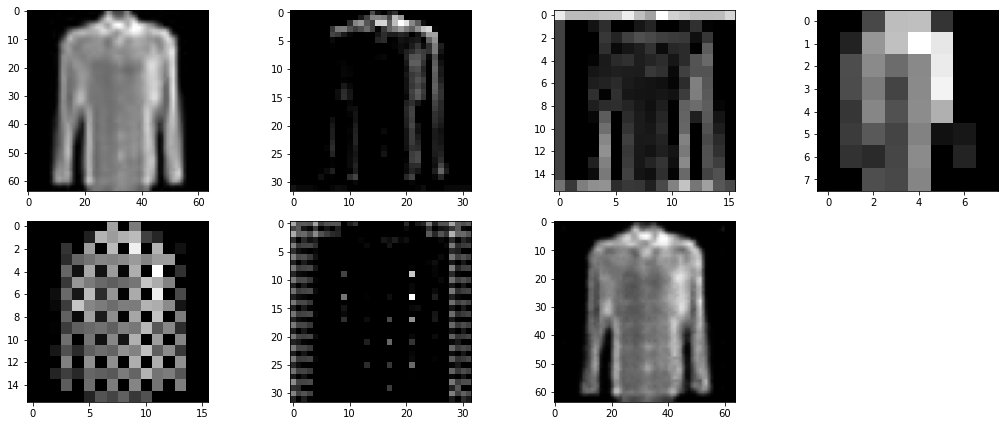

In [91]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
batch_iterator = iter(test_dataloader)
images = next(batch_iterator)

input_x = images[0][0].to(device)
input_x = input_x.view(1,1,input_x.size(0),input_x.size(1))
fig = plt.figure(figsize=(15,6))
plt.subplot(2,4,1)
plt.imshow(input_x[0][0].to('cpu').detach().numpy(),'gray')

outputs = CAE_trained(input_x)
for i in range(6):
    plt.subplot(2,4,i+2)
    image = outputs[i][0][0].to('cpu').detach().numpy()
    plt.imshow(image,'gray')
plt.tight_layout(pad=1.0)

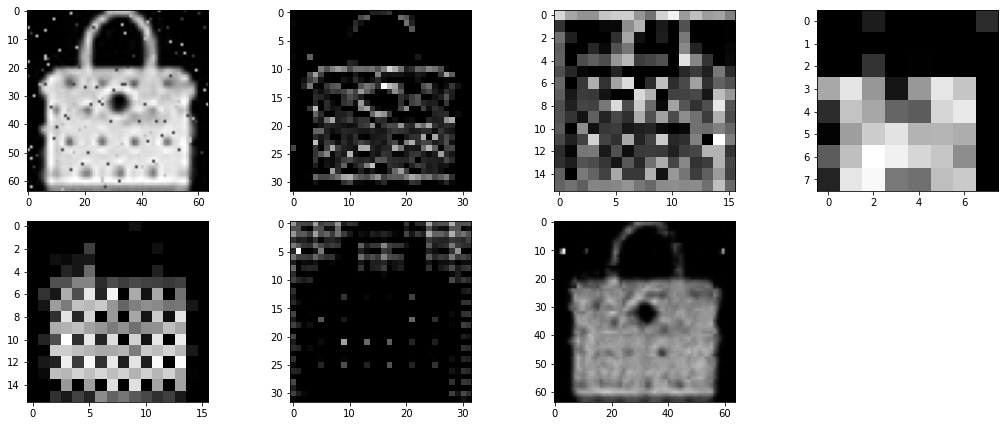

In [112]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
batch_iterator = iter(test_dataloader)
images = next(batch_iterator)

input_x = images[0][0].to(device)
input_x = input_x.view(1,1,input_x.size(0),input_x.size(1))
for i in range(64):
  x = random.randint(0,63)
  y = random.randint(0,63)
  input_x[0][0][x][i] = -0.5
  input_x[0][0][i][y] = 0.5
fig = plt.figure(figsize=(15,6))
plt.subplot(2,4,1)
plt.imshow(input_x[0][0].to('cpu').detach().numpy(),'gray')

outputs = CAE_trained(input_x)
for i in range(6):
    plt.subplot(2,4,i+2)
    image = outputs[i][0][0].to('cpu').detach().numpy()
    plt.imshow(image,'gray')
plt.tight_layout(pad=1.0)